In [1]:
# demo de-noising using fhmm
# this was attempt 1, all is working but need to streamline so that
# it's simpler to run lots of tests

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/tests/selecting_nfft_size', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import librosa
import torchaudio
import numpy as np
import config
import os.path
import math
import os
import pathlib
import random
import torch
import utils
import warnings
import my_torch.torchio as tio
import torchaudio.functional as F
import torchaudio.transforms as T

In [15]:
from whale.setup import get_data, constants, annotations
import importlib
importlib.reload(constants)

importlib.reload(get_data)
from final import useful
importlib.reload(useful)

HUMPBACK_A = 'humpback_a'
HUMPBACK_B = 'humpback_b'
BOWHEAD = 'bowhead'
NOISE = 'noise'

# constants for fe and what not
fs = 4000

signal_types = [HUMPBACK_A, HUMPBACK_B, BOWHEAD, NOISE]

# type to label
signal_types_labels = {
    HUMPBACK_A: 0,
    HUMPBACK_B: 1,
    BOWHEAD: 2,
    NOISE: 3
}

# label to type
label_to_type = {
    0: HUMPBACK_A,
    1: HUMPBACK_B,
    2: BOWHEAD,
    3: NOISE
}

get_data_dict = {
    HUMPBACK_A: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.SWOOPS_LABELS_A, fs, useful.file_to_audio)],
    HUMPBACK_B:[get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HIGH_CALLS_LABELS_A, fs, useful.file_to_audio)],
    BOWHEAD: [get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_WHALE, fs, useful.file_to_audio)],
    NOISE: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HUMPBACK_LABEL_A_NOISE, fs, useful.file_to_audio),
            get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_NOISE, fs, useful.file_to_audio)]
}

samples, labels = useful.get_samples(get_data_dict, signal_types, signal_types_labels)

__collected samples__
humpback_a :  18
humpback_b :  11
bowhead :  34
noise :  62


In [16]:
import noisey

def get_feature(samp, nfft):
    # add optionals here if needed
    # mfcc
    # feat = librosa.feature.mfcc(y=samp,sr=4000,n_mfcc=13).T
    feat = useful.get_log_power_feature(samp, nfft=nfft)
    return feat

signal_avg_db = -16 # from inspection

def get_noise_for_sample(sig_db, sample, snr_1=30, snr_2=30, snr_3=30):
    noise_power_1 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_1)
    noise_power_2 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_2)
    noise_power_3 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_3)
    noise_sample, _ = noisey.generate_gaussian_noise(len(sample), noise_power_1, noise_power_2, noise_power_3)
    return noise_sample

In [17]:
# separate using cross-validation
import final.cross_validation as cv
from final.cross_validation import *
import importlib
importlib.reload(cv)

n_folds = 2
cv_output = cv.split_data_for_cross_validation(samples, labels, n_folds, test_ratio=0.2)

In [31]:
cv_index = 1    # select train and test for this iteration
importlib.reload(useful)
train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])
test = useful.SampleHolder(cv_output[TEST_DATA], cv_output[TEST_LABEL])

from hmmlearn.hmm import GaussianHMM

n_components = 8
nffts = [64, 128, 256, 512, 1024]
nfft_index = 0
snrdb = 10

dicts_results = {}

In [ ]:
for nffts in

In [32]:
for nfft_index in range(len(nffts)):
    print('nfft_index', nfft_index)

    for i in range(2):
        print('fold', i)
        cv_index = i

        print('results for: ', nffts[nfft_index], 'fold: ', cv_index)

        hmms = {
            HUMPBACK_A: GaussianHMM(n_components),
            HUMPBACK_B: GaussianHMM(n_components),
            BOWHEAD: GaussianHMM(n_components),
            NOISE: GaussianHMM(5)
        }

        train.features = []
        for sample in train.samples:
            train.features.append(get_feature(sample, nffts[nfft_index]))

        for key in hmms:
            cur_hmm = hmms[key]
            feat_indicis = train.sample_labels == signal_types_labels[key]
            hmm_features = [item for item, condition in zip(train.features, feat_indicis) if condition]
            cur_hmm.fit(np.concatenate(hmm_features))

        # get accuracy measure then decode combine
        import sklearn.metrics
        from final.tests import decode_combine as dc
        importlib.reload(dc)
        combined_model = dc.DecodeCombineGaussian([hmm for hmm in hmms.values()])

        importlib.reload(useful)
        val.features = []
        noise_samples = []
        noise_features = []
        for i in range(len(val.samples)):

             # ---- noise / reverb adjustments ---- START
            noise_sample = get_noise_for_sample(signal_avg_db, val.samples[i], snrdb, snrdb, 30)
            noise_samples.append(noise_sample)
            noise_features.append(get_feature(noise_sample, nfft=nffts[nfft_index]))
            adjusted_sample = val.samples[i] + noise_sample
            # ---- noise / reverb adjustments ---- END

            feature = get_feature(adjusted_sample, nfft=nffts[nfft_index])
            val.features.append(feature)
        val.update_feature_labels()

        noise_hmm = GaussianHMM(5, covariance_type='full', init_params='')
        noise_hmm.fit(np.concatenate(noise_features))

        test.features = []
        for i in range(len(test.samples)):

            # ---- noise / reverb adjustments ---- START
            noise_sample = get_noise_for_sample(signal_avg_db, test.samples[i], snrdb, snrdb, 30)
            noise_samples.append(noise_sample)
            noise_features.append(get_feature(noise_sample, nfft=nffts[nfft_index]))
            adjusted_sample = test.samples[i] + noise_sample
            # ---- noise / reverb adjustments ---- END

            feature = get_feature(adjusted_sample, nfft=nffts[nfft_index])
            test.features.append(feature)
        test.update_feature_labels()

        import time
        import pandas as pd

        from final.models.fhmm import FactorialHMM

        fhmms = {}
        for key in hmms:
            fhmm = FactorialHMM(hmms[key], noise_hmm)
            fhmms[key] = fhmm.hmm

        combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])

        # validation
        start = time.time()
        _, val_pred, _ = combined_model_fhmm.decode_hmmlearn(np.concatenate(val.features))
        end = time.time()
        print('time', end - start)
        metrics = useful.perf_measure(np.concatenate(val.feature_labels), val_pred)
        metrics['time'] = end - start
        df = pd.DataFrame([metrics])

        # test
        _, val_pred, _ = combined_model_fhmm.decode_hmmlearn(np.concatenate(test.features))
        metrics = useful.perf_measure(np.concatenate(test.feature_labels), val_pred)
        metrics['time'] = 0
        df_new = pd.DataFrame([metrics])

        df = pd.concat([df, df_new],  ignore_index=True)

        dicts_results[str(nfft_index) + str(cv_index)] = df

        # Assuming 'result' is your DataFrame
        # df.to_csv('output.csv', index=False)

        # {'acc': 0.8788552375659906, 'tpr': 0.992887029288703, 'fpr': 0.3465674110835401}      | 30 db snr
        # {'acc': 0.37735085945399394, 'tpr': 0.2629573170731707, 'fpr': 0.17641228939544104}   | 10 db snr

nfft_index 0
fold 0
results for:  64 fold:  0
time 1.1835620403289795
fold 1
results for:  64 fold:  1
time 1.192730188369751
nfft_index 1
fold 0
results for:  128 fold:  0
time 0.9681718349456787
fold 1
results for:  128 fold:  1
time 0.9726767539978027
nfft_index 2
fold 0
results for:  256 fold:  0
time 0.9275012016296387
fold 1
results for:  256 fold:  1
time 0.9444370269775391
nfft_index 3
fold 0
results for:  512 fold:  0
time 1.1576602458953857
fold 1
results for:  512 fold:  1
time 1.2204389572143555
nfft_index 4
fold 0
results for:  1024 fold:  0
time 1.8331520557403564
fold 1
results for:  1024 fold:  1
time 1.9089949131011963


In [34]:
concatenated_df = pd.concat(dicts_results.values(), axis=0, ignore_index=True)

In [14]:
useful.perf_measure(np.concatenate(test.feature_labels), val_pred)

{'ACC': 0.6971830985915493,
 'TPR': 0.6911764705882353,
 'FPR': 0.2972972972972973,
 'TNR': 0.7027027027027027,
 'PPV': 0.6811594202898551,
 'NPV': 0.7123287671232876,
 'FNR': 0.3088235294117647,
 'FDR': 0.3188405797101449}

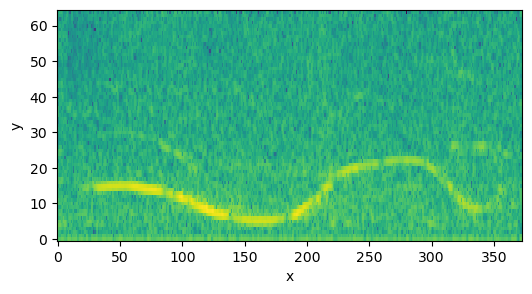

In [154]:
import final.useful
useful.vis_helper(test.features[-1])

time 0.41472601890563965


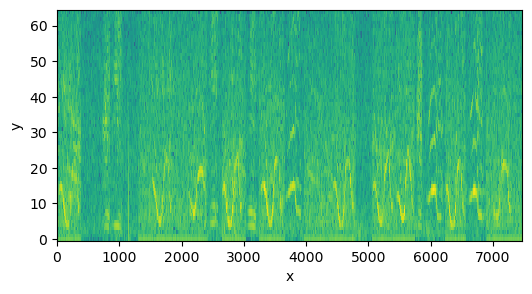

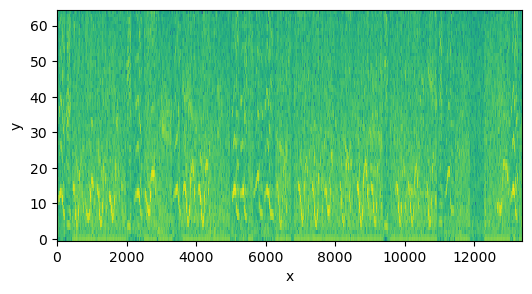

In [37]:
import final.useful
useful.vis_helper(np.concatenate(test.features))
useful.vis_helper(np.concatenate(val.features))


In [109]:
# optional create FHMM's
noise_hmm = GaussianHMM(5, covariance_type='full', init_params='')
noise_hmm.fit(np.concatenate(noise_features))

GaussianHMM(covariance_type='full', init_params='', n_components=3)

In [110]:
from final.models.fhmm import FactorialHMM

fhmms = {}
for key in hmms:
    fhmm = FactorialHMM(hmms[key], noise_hmm)
    fhmms[key] = fhmm.hmm

combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])

_, val_pred_fhmm, val_log_prob_fhmm = combined_model_fhmm.decode_hmmlearn(np.concatenate(val.features))
accuracy = useful.perf_measure(np.concatenate(val.feature_labels), val_pred_fhmm)
print(accuracy)

{'acc': 0.8595594020456334, 'tpr': 0.9012158054711246, 'fpr': 0.2852112676056338}


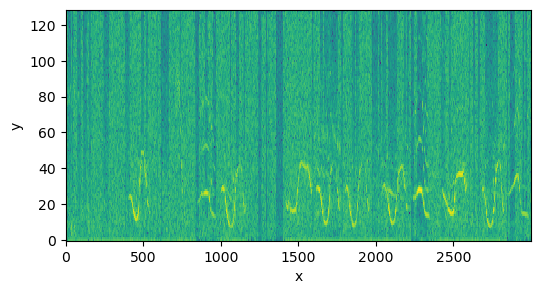

In [84]:
useful.vis_helper(np.concatenate(val.features)[:3000])

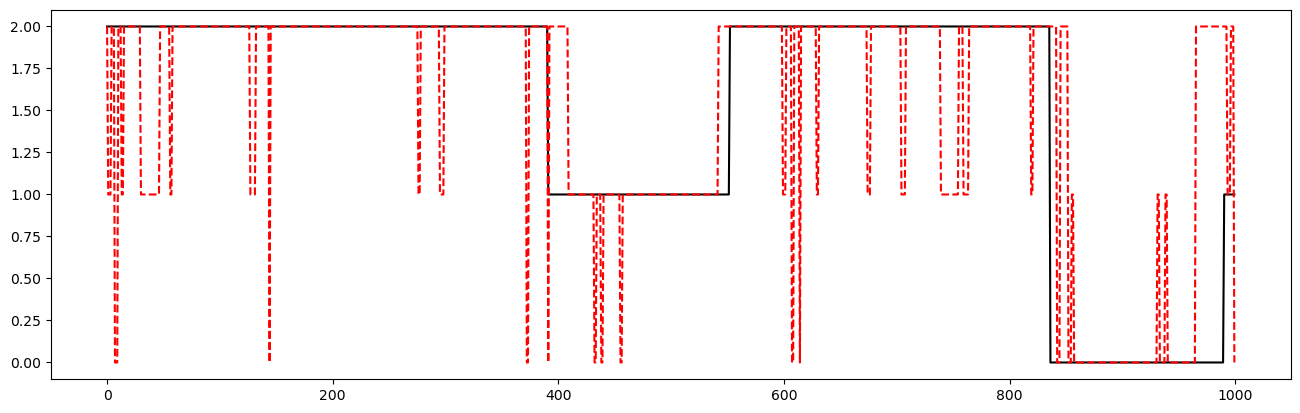

In [77]:
# val subset

val_true_subset = np.concatenate(val.feature_labels)[:1000]
val_pred_subset = val_pred_fhmm[:1000]
val_features_subset = np.concatenate(val.features)[:1000]

import matplotlib.pyplot as plt
plt.plot(val_true_subset, c='black')
plt.plot(val_pred_subset, '--', c='red')
# useful.vis_helper(val_features_subset)

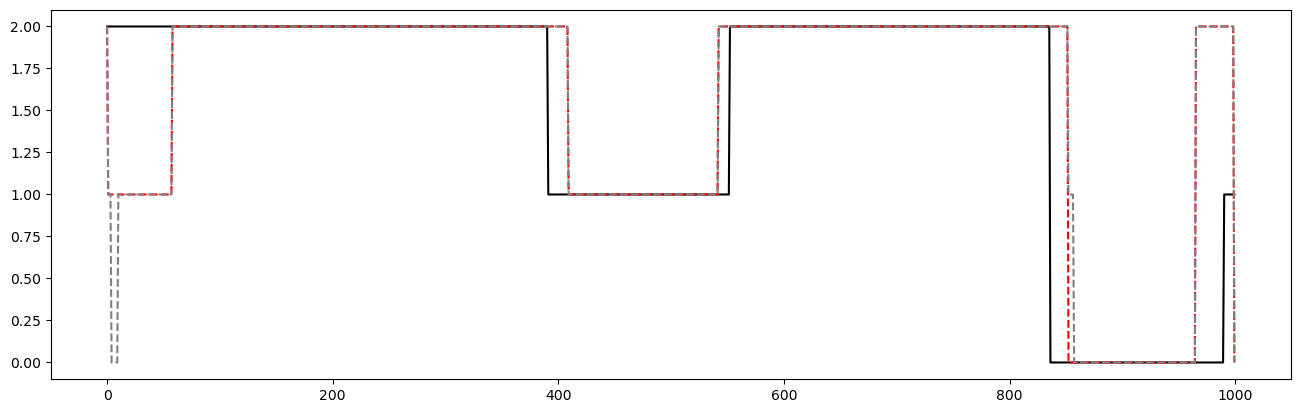

In [78]:
importlib.reload(useful)

val_pred_subset_smoothed = useful.smooth_labels(val_pred_subset)
plt.plot(val_true_subset, c='black')
plt.plot(useful.smooth_labels(val_pred_subset_smoothed), '--', c='red')
plt.plot(val_pred_subset_smoothed, '--', c='grey')

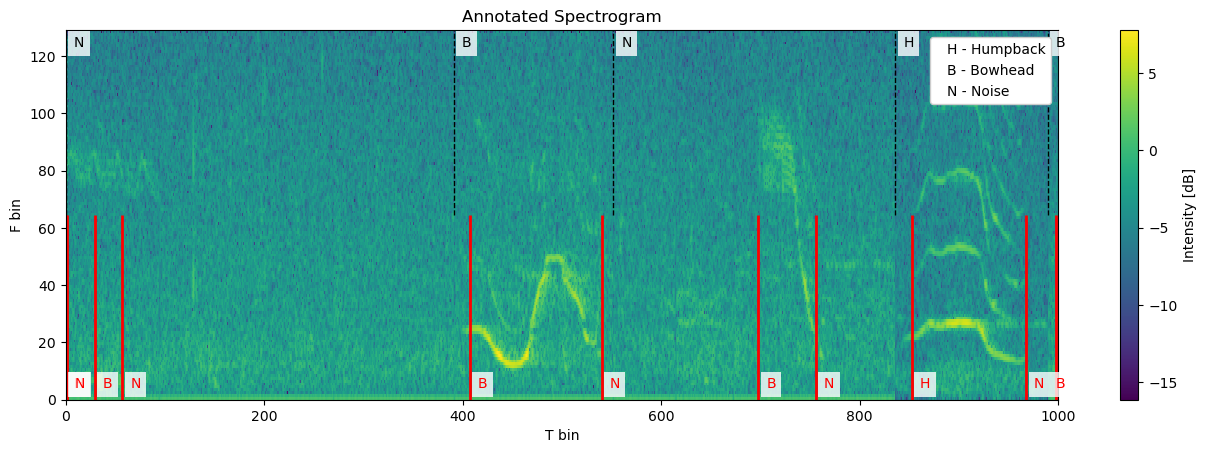

In [27]:
label_to_abr = {
    0: 'H',
    1: 'B',
    2: 'N'
}

useful.plot_spectrogram(val_features_subset, val_true_subset, useful.smooth_labels(val_pred_subset_smoothed), label_to_type, label_to_abr)

# Testing

In [46]:
# adjustment for sliding windows and noise introduction

importlib.reload(useful)

train_noise_indices = train.sample_labels == signal_types_labels['noise']
train_noise_samples = [item for item, condition in zip(train.samples, train_noise_indices) if condition]

# adjust samples so that there are more noise samples, and in the middle there is a long break
new_test_labels = []
new_test_samples = []

for i in range(len(test.samples)):
    new_test_samples.append(test.samples[i])
    new_test_labels.append(test.sample_labels[i])
    if int(test.sample_labels[i]) is not signal_types_labels['noise']:
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
    if i == len(test.samples) // 2:
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])

test_new = useful.SampleHolder(new_test_samples, [int(num) for num in new_test_labels])

In [47]:
test_new.features = []
test_noise_samples = []
test_noise_features = []

for i in range(len(test_new.samples)):
    if i < len(test_new.samples) // 2:
         feature = get_feature(test_new.samples[i])
    else:
        # ---- noise / reverb adjustments ---- START
        noise_sample = get_noise_for_sample(signal_avg_db, test_new.samples[i], 5, 5, 30)
        test_noise_samples.append(noise_sample)
        test_noise_features.append(get_feature(noise_sample))
        adjusted_sample = test_new.samples[i] + noise_sample
        # ---- noise / reverb adjustments ---- END
        feature = get_feature(adjusted_sample)
    test_new.features.append(feature)
test_new.update_feature_labels()

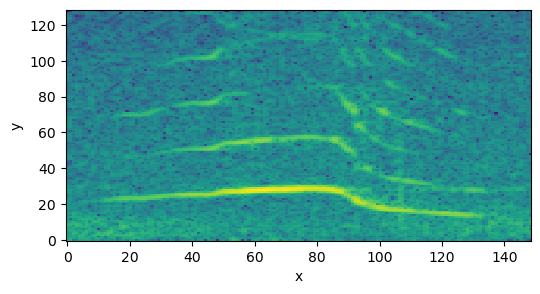

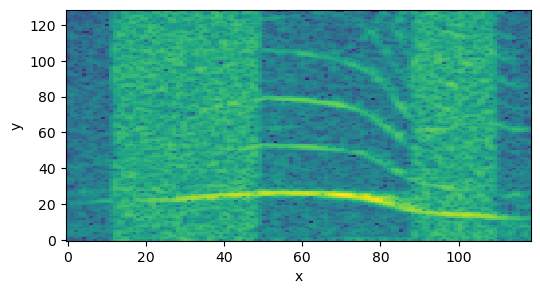

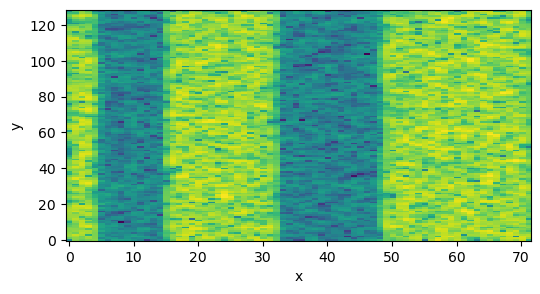

In [50]:
useful.vis_helper(train.features[5])
useful.vis_helper(test_new.features[-3])
useful.vis_helper(test_noise_features[0])

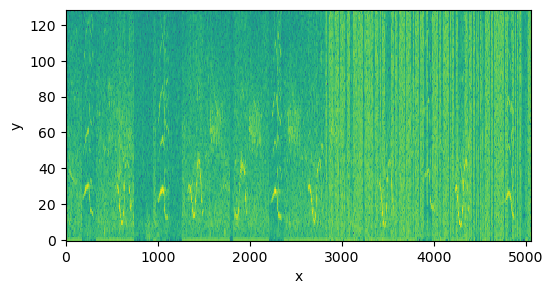

{'acc': 0.49928109273903665, 'tpr': 0.360093896713615, 'fpr': 0.046012269938650305}


In [113]:
test_features_concat = np.concatenate(test_new.features)
_, test_pred, test_log_prob = combined_model.decode_hmmlearn(test_features_concat)
useful.vis_helper(test_features_concat)
accuracy = useful.perf_measure(np.concatenate(test_new.feature_labels), test_pred)
print(accuracy)
## use fhmm_dc from above trained on noise as well

In [106]:
noise_hmm = GaussianHMM(3, covariance_type='full', init_params='')
noise_hmm.fit(np.concatenate(test_noise_features))

fhmms = {}
for key in hmms:
    fhmm = FactorialHMM(hmms[key], noise_hmm)
    fhmms[key] = fhmm.hmm

combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])

_, val_pred_fhmm, val_log_prob_fhmm = combined_model_fhmm.decode_hmmlearn(np.concatenate(test_new.features)[3000:])
accuracy = useful.perf_measure(np.concatenate(test_new.feature_labels)[3000:], val_pred_fhmm)
print(accuracy)

{'acc': 0.7852998065764023, 'tpr': 0.7569230769230769, 'fpr': 0.16666666666666666}


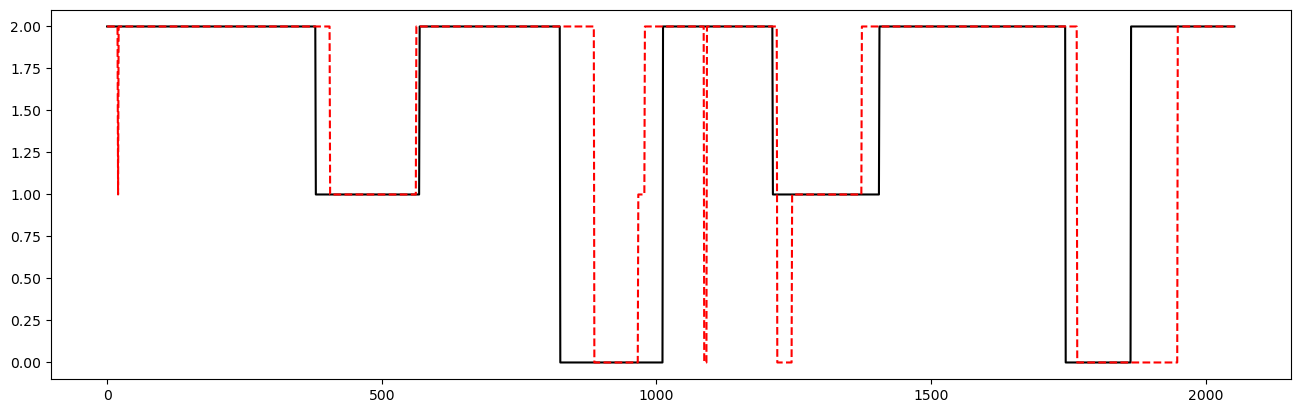

In [104]:
plt.plot(np.concatenate(test_new.feature_labels)[3000:], c='black')
plt.plot(useful.smooth_labels(val_pred_fhmm), '--', c='red')

In [114]:
# insert for adaptive noise handling
# update noise hmm to bayesian / HDP ?

class NoiseAdaptiveHMM:
    def __init__(self, dc_model: dc.DecodeCombineGaussian, signal_hmms, n_hmm: GaussianHMM):
        self.dc_model: dc.DecodeCombineGaussian = dc_model
        self.signal_hmms = signal_hmms  # dict with hmms inside
        self.n_hmm = n_hmm

    def update_model(self, new_noise_features):
        # new noise features, aim is to update fhmms and then dc_model
        self.n_hmm.fit(new_noise_features)

        updated_fhmms = {}
        for key in self.signal_hmms:
            updated_fhmm = FactorialHMM(hmms[key], self.n_hmm)
            updated_fhmms[key] = updated_fhmm.hmm

        self.dc_model = dc.DecodeCombineGaussian([u_fhmm for u_fhmm in updated_fhmms.values()])

        print('model updated to changing noise conditions')


def sliding_windows(data, window_size, step_size, na_hmm: NoiseAdaptiveHMM, mean_log_prob, threshold = 1.2, re_train_buffer=10):
    output = {
        'noise_data': []
    }
    windows = []
    log_probs = []
    std_probs = []
    states_decoded = np.zeros(len(data))
    window_indices = []

    train_counter = 0


    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i+window_size, :]

        # do stuff here
        _, test_pred, log_prob = na_hmm.dc_model.decode_hmmlearn(window)
        log_probs.append(log_prob)
        states_decoded[i:i+window_size] = test_pred
        windows.append(window)
        window_indices.append(i)
        std_probs.append(np.std(log_probs[-3:]))

        # avoid re-training a lot
        if train_counter > 0:
            train_counter -= 1

        # if likelihood drops bellow threshold then re-train noise hmm and update other hmms
        # maybe don't compare to complete std mean here ?
        if np.mean(log_probs[-10:]) < mean_log_prob * threshold and std_probs[-1] < np.mean(std_probs) and train_counter == 0:
            # use last 3 windows to train noise hmm
            # data[i:i + (step_size * 3)]
            start_index = window_indices[-3]
            noise_data = data[start_index:start_index + (step_size * 10)]
            na_hmm.update_model(noise_data)

            output['noise_data'].append(noise_data)

            # start buffer to avoid a lot of re-training
            train_counter = re_train_buffer

    output['windows'] = np.array(windows)
    output['prob'] = log_probs
    output['states'] = states_decoded
    return output

# Define sliding window parameters
window_size = 200
step_size = 50
my_na_hmm = NoiseAdaptiveHMM(combined_model, hmms, noise_hmm)
out = sliding_windows(test_features_concat, window_size, step_size, my_na_hmm, -50000, 1.2)
windows_states = out['states']

model updated to changing noise conditions


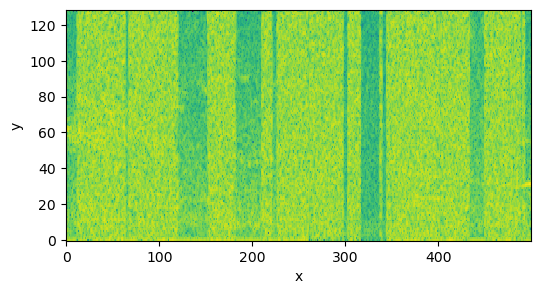

In [59]:
useful.vis_helper(out['noise_data'][0])

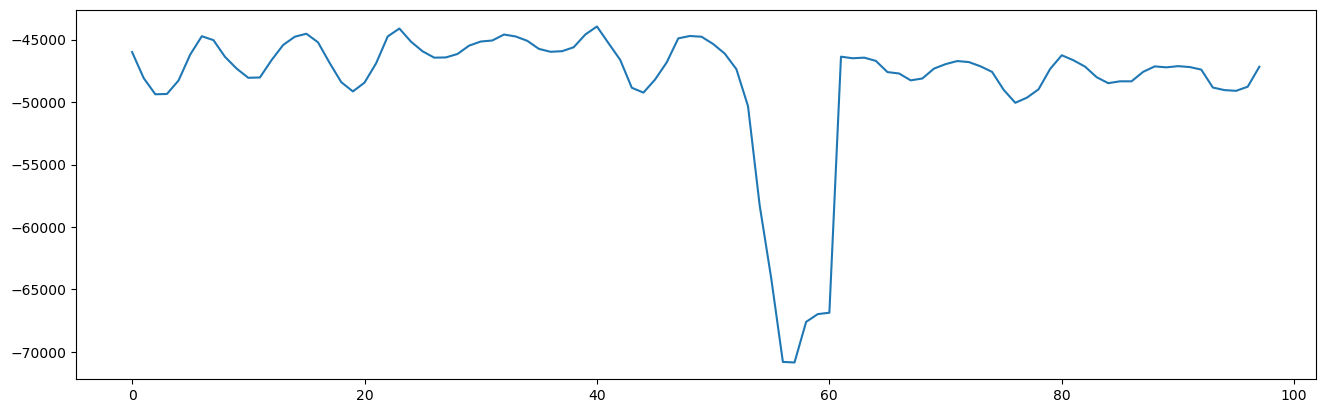

In [115]:
# close_test = np.isclose(windows_states, test_pred[:len(windows_states)])
plt.plot(out['prob'])

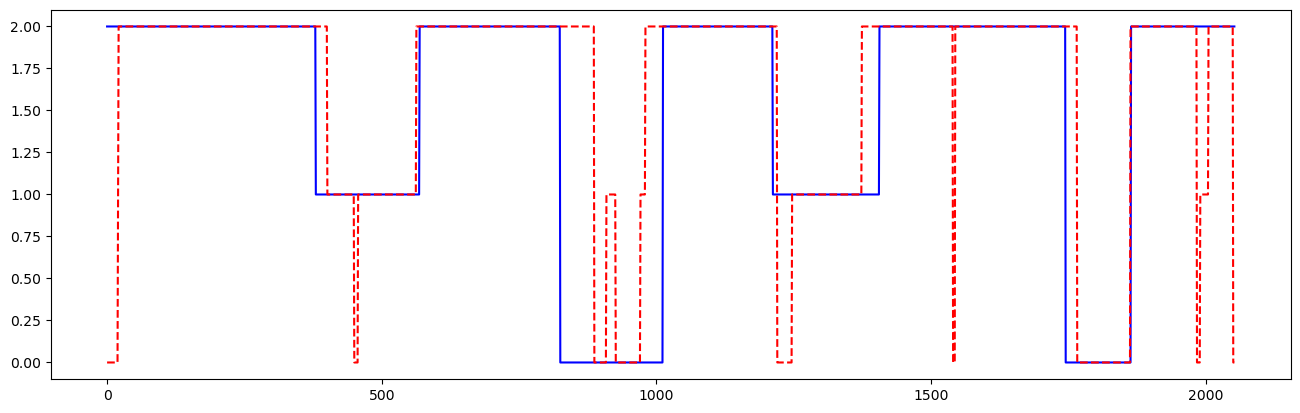

In [117]:
plt.plot(np.concatenate(test_new.feature_labels)[3000:], c='b')
plt.plot(useful.smooth_labels(windows_states[3000:]), '--', c='r')
# plt.plot(useful.smooth_labels(windows_states[3000:]), '--', c='g')

In [119]:
accuracy = useful.perf_measure(np.concatenate(test_new.feature_labels)[3000:], useful.smooth_labels(windows_states[3000:]))
print(accuracy)

{'acc': 0.8036036036036036, 'tpr': 0.8080229226361032, 'fpr': 0.20388349514563106}


In [34]:

smoothed_labels = useful.smooth_labels(test_pred_subset)
# print("Original Labels:", labels)
# print("Smoothed Labels:", smooth_labels(labels))

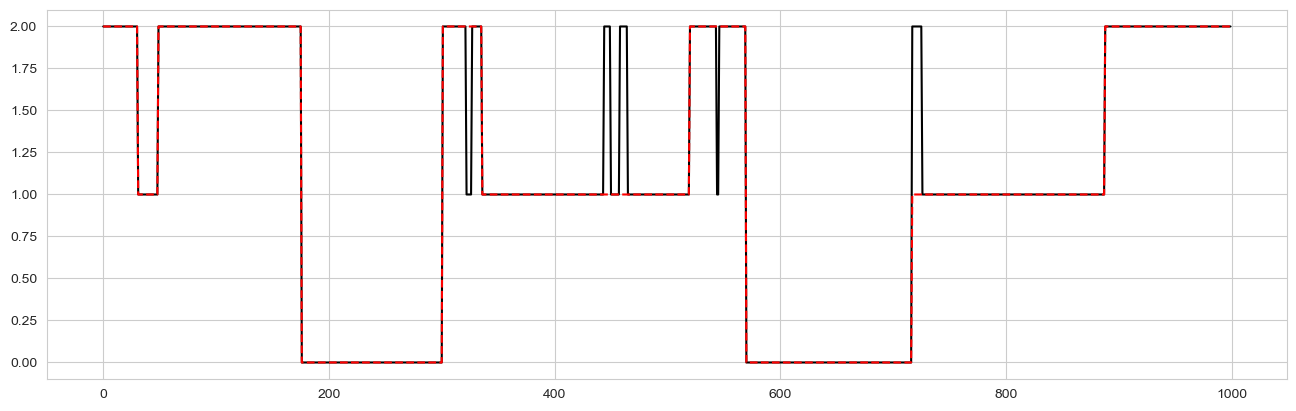

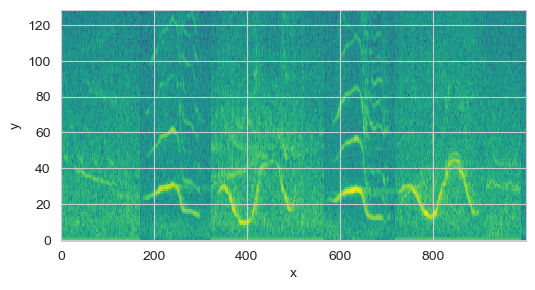

In [35]:
import matplotlib.pyplot as plt
plt.plot(test_pred_subset, c='black')
plt.plot(smoothed_labels, '--', c='red')
useful.vis_helper(test_features_concat_subset)

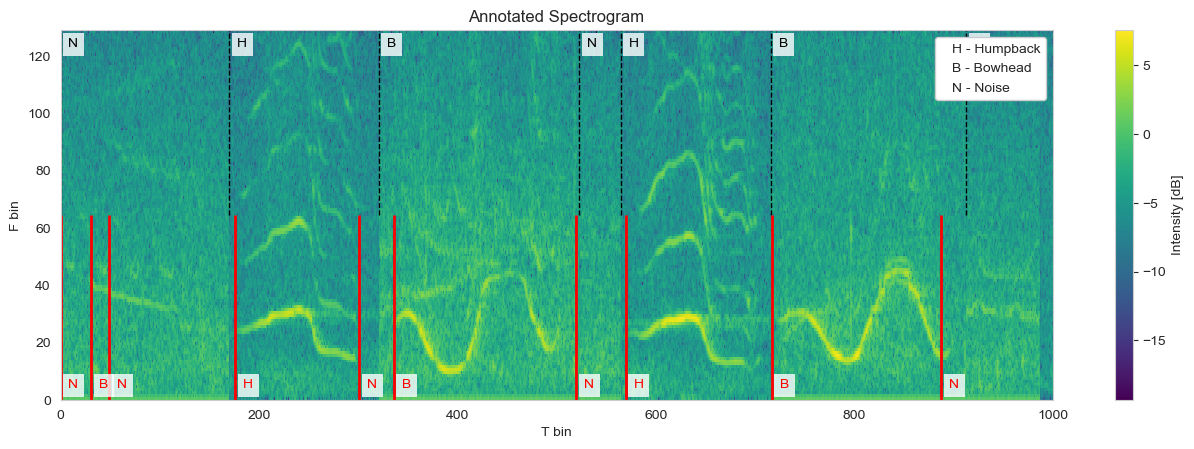

In [36]:
# plot spectrogram showing models and given annots,
importlib.reload(useful)

label_to_abr = {
    0: 'H',
    1: 'B',
    2: 'N'
}

useful.plot_spectrogram(test_features_concat_subset, np.concatenate(test.feature_labels)[:1000], smoothed_labels, label_to_type, label_to_abr)